In [1]:
from Bio.SeqIO.FastaIO import SimpleFastaParser
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import os, sys
import pandas as pd
import pybedtools as pb

import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

LOCAL = False
if LOCAL is True:
    sys.path.append("/Users/sarahfong/tools/py_")
    PATH = "/Users/sarahfong/Desktop/local_data/Biomarin_Jun_2023/"
    RE = os.path.join(PATH, "results")
    CONFIG_NAME="config.local.neuron.mpra.ini"
else:
    PATH="/wynton/group/ahituv/biomarin/data"
    RE = "/wynton/group/ahituv/biomarin/results"
    RE_MAPS = os.path.join(RE, "enh_maps")
    CONFIG_NAME="config.neuron.mpra.orig.ini"
import config_readwrite as crw
import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

In [2]:
config, cfn = crw.read(CONFIG_NAME)

section = 'lib2'
crw.check(config, section)

In [3]:
if "fasta" not in list(config[section]):  # write files to config

    MPRA = os.path.join(PATH, "delta_rank.csv")

    FASTA = os.path.join(PATH, "library_2", "Design",
                         "biomarin-lib2-hg38-final.fasta")
    META_DATA = os.path.join(PATH, "lib2.meta_data.tsv")

    DELTA_ACTIVITY = os.path.join(PATH, "deltaMPRA.gaba.minus.glut.tsv")
    DELTA_ACTIVITY_Z = os.path.join(PATH, "deltaMPRA.gaba.minus.glut.zscore.tsv")
    SIG_ACTIVITY_Z = os.path.join(PATH, "WilcoxonSig.gaba.glut.zscore.tsv")
    VISTA = os.path.join(PATH, "vista.lib2.tiles.bed")

    # delta MPRA activity
    config[section]["delta.mpra_richa"] = MPRA
    config[section]["delta.mpra_centered"] = DELTA_ACTIVITY
    config[section]["delta.mpra_centeredz"] = DELTA_ACTIVITY_Z

    config[section]["fasta"] = FASTA

    # genome coordinates
    config[section]["tile_bed"] = TILE_BED
    config[section]["enh_bed"] = ENH_BED

    # GREAT
    config[section]["great_nearest"] = GREAT_GENE_TSV

    # meta_data
    config[section]["metadata"] = META_DATA

    # significance GABA v. GLUT
    config[section]["sig-wilcoxon"] = SIG_ACTIVITY_Z

    # vista
    config[section]["vista"] = VISTA
    crw.write(config, cfn)

else:
    MPRA = config[section]["delta.mpra_richa"]
    DELTA_ACTIVITY = config[section]["delta.mpra_centered"]
    DELTA_ACTIVITY_Z = config[section]["delta.mpra_centeredz"]

    FASTA = config[section]["fasta"]

    TILE_BED = config[section]["tile_bed"]
    ENH_BED = config[section]["enh_bed"]

    GREAT_GENE_TSV = config[section]["great_nearest"]
    META_DATA = config[section]["metadata"]

    SIG_ACTIVITY_Z = config[section]["sig-wilcoxon"]
    VISTA = config[section]["vista"]

In [4]:
meta = pd.read_csv(META_DATA, sep='\t')
delta = pd.read_csv(DELTA_ACTIVITY_Z, sep='\t')

len(set(meta["enh.id"]))

1828

In [5]:
delta.shape

(35371, 10)

# load MPRA data

In [6]:
mpra = pd.read_csv(MPRA)

mpra

,name,gaba_log2_mean,glut_log2_mean,delta,delta_rank
0,chr1:10339772-10340042,-1.602773,0.466691,-2.069465,1.0
1,chr6:154127563-154127833,-0.460660,1.393760,-1.854420,2.0
2,chr4:93216597-93216867,-1.373226,0.426283,-1.799509,3.0
3,chr9:127735295-127735565,-0.784093,1.010851,-1.794944,4.0
4,chr1:31376876-31377146,-0.500106,1.291683,-1.791789,5.0
...,...,...,...,...,...
35366,chr9:127613026-127613296,0.758066,-0.412615,1.170681,35367.0
35367,chr10:97633041-97633311,0.727817,-0.488544,1.216361,35368.0
35368,chr10:32056179-32056449,0.861082,-0.358334,1.219416,35369.0
35369,chr10:97633021-97633291,0.614040,-0.609305,1.223346,35370.0


## filter to keep only synthetics

In [7]:
mpra=mpra.loc[mpra["name"].str.contains("seq")]

print(mpra.shape)
mpra.head()

(968, 5)


,name,gaba_log2_mean,glut_log2_mean,delta,delta_rank
7,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-1.754227,-0.005828,-1.748399,8.0
8,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-1.581979,0.136294,-1.718273,9.0
12,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-1.807870,-0.113684,-1.694187,13.0
16,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-1.809980,-0.147642,-1.662338,17.0
17,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-1.470171,0.191895,-1.662066,18.0


[Text(0.5, 1.0, 'delta MPRA'),
 Text(0.5, 0, 'delta\nmean log2(gaba) - mean log2(glut)')]

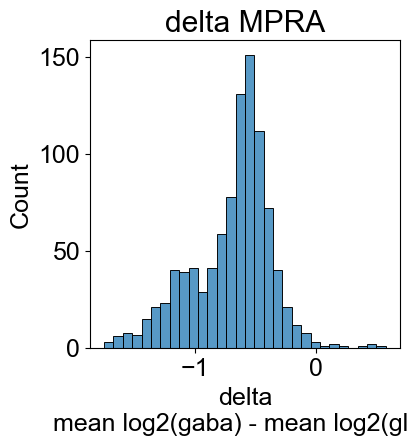

In [8]:
fig, ax = plt.subplots(figsize=(4,4))
sns.histplot(mpra["delta"])
ax.set(title="delta MPRA",
      xlabel="delta\nmean log2(gaba) - mean log2(glut)")
#plt.savefig(os.path.join(RE, "deltas.syn.pdf"), bbox_inches="tight")

In [9]:
mpra["delta"].describe()

count    968.000000
mean      -0.694709
std        0.331497
min       -1.748399
25%       -0.877441
50%       -0.617139
75%       -0.488991
max        0.576515
Name: delta, dtype: float64

# filter for shuffled sequences. 
## meta data (library)

In [10]:
enh = meta.loc[meta["bkgd"]==True]

# rename columns for merging with MPRA data
enh = enh.rename(columns ={"start":"start.tile",
                           "end":"end.tile"})

print(enh.shape)
enh.head()

(1296, 15)


,name,sequence,bkgd,72h,ctrl,cl,coor,top_bottom,strand,#chr,start.tile,end.tile,enh.id,enh.name,tile.order
3791,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,627.0
3792,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,603.0
3793,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,579.0
3794,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,555.0
3795,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,629.0


## MPRA activity

In [11]:
enh = pd.merge(enh, mpra, how="left", left_on="name",
               right_on="name").drop_duplicates()
print(enh.shape)
enh.head()

(1296, 19)


,name,sequence,bkgd,72h,ctrl,cl,coor,top_bottom,strand,#chr,start.tile,end.tile,enh.id,enh.name,tile.order,gaba_log2_mean,glut_log2_mean,delta,delta_rank
0,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,627.0,-1.527215,-0.690321,-0.836894,1646.0
1,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,603.0,-1.283744,-0.738124,-0.545619,4857.0
2,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,579.0,-1.591621,-0.832101,-0.759520,2236.0
3,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,555.0,NaN,NaN,NaN,NaN
4,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,629.0,-1.456528,-0.845583,-0.610945,3856.0


In [12]:
enh = pd.merge(enh, delta, how="left", left_on ="name", right_on="name").drop_duplicates()

enh.shape

(1296, 28)

# add significance data

In [13]:
sig_reps= pd.read_csv(SIG_ACTIVITY_Z, sep='\t')
print(sig_reps.shape)
sig_reps.head()

(35371, 11)


,name,gaba_1,gaba_2,gaba_3,glut_1,glut_2,glut_3,pval,fdr_bool,fdr,-log10p_fdr
0,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.794103,-2.970164,-2.334829,-1.249982,-1.717908,-2.121743,0.037107,False,0.119390,0.923032
1,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.671559,-2.830269,-2.548998,-1.803647,-3.098993,-0.318147,0.361064,False,0.493535,0.306682
2,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.273753,-2.155235,-2.255196,-2.009413,-2.922402,-0.596232,0.626615,False,0.728743,0.137425
3,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.705924,-2.665966,-2.627832,-0.626111,-2.827502,-1.210420,0.233208,False,0.364764,0.437989
4,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.645673,-2.565910,-3.058675,-2.246619,-1.618896,-3.649946,0.719958,False,0.801537,0.096076


### 23 synthetic sequences are significantly different by t-test?

In [14]:
sig_reps.loc[sig_reps["name"].isin(enh['name'])].groupby(["fdr_bool"])["name"].count()

fdr_bool
False    945
True      23
Name: name, dtype: int64

## example of significant, non-significant reps

In [15]:
sig_reps.sample(n=3)

,name,gaba_1,gaba_2,gaba_3,glut_1,glut_2,glut_3,pval,fdr_bool,fdr,-log10p_fdr
11994,chr17:50628505-50628775,0.716251,0.837346,0.799780,0.482990,0.144897,0.000201,0.049386,False,0.138780,0.857673
13108,chr19:13505749-13506019,1.037668,1.332457,1.302957,0.562781,0.630150,0.503066,0.011108,False,0.067927,1.167958
8306,chr14:35292746-35293016,-1.884111,-1.734930,-1.777424,-1.944188,-1.074243,-1.277231,0.296205,False,0.430097,0.366433


## re compute delta? 

In [16]:
# merge synthetic + significant results
enh= pd.merge(enh, sig_reps, how="left").drop_duplicates()

# label significant elements, alpha = 0.05
enh["sig"] = enh["fdr"].apply(lambda x: True if x<0.05 else False)

# get means
enh["gaba"] = enh[["gaba_1", "gaba_2", "gaba_3"]].mean(axis=1)

enh["glut"] = enh[["glut_1", "glut_2", "glut_3"]].mean(axis=1)

# recompute delta
enh["delta.gaba-glut"] = enh["gaba"]-enh["glut"]

enh.head()

,name,sequence,bkgd,72h,ctrl,cl,coor,top_bottom,strand,#chr,...,fdr,-log10p_fdr,gaba_1,gaba_2,gaba_3,glut_1,glut_2,glut_3,pval,fdr_bool
0,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,...,0.173911,0.759672,-2.421393,-2.184369,-2.227760,-1.956195,-1.840061,-1.376951,0.072685,False
1,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,...,0.817770,0.087369,-2.019538,-1.677746,-2.074945,-2.181752,-1.903716,-1.406938,0.741336,False
2,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,...,0.061749,1.209370,-2.352699,-2.466286,-2.295281,-2.131924,-1.977559,-2.010440,0.008621,False
3,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,...,0.591141,0.228309,-2.211512,-1.975496,-2.338388,-2.062864,-1.947051,-2.200030,0.466315,False


## plot sig deltas

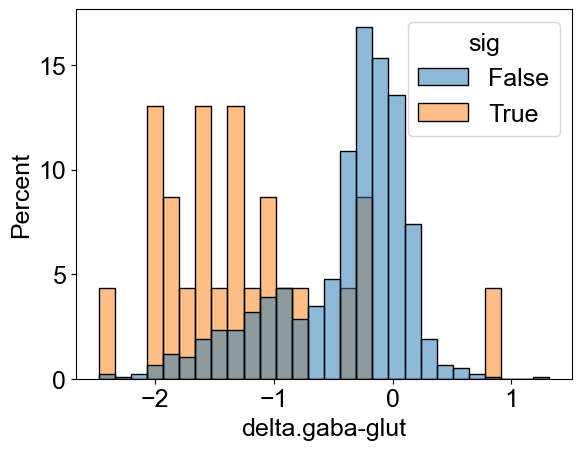

In [17]:
sns.histplot(x="delta.gaba-glut", data=enh, hue="sig", stat="percent", common_norm=False)
out = os.path.join(RE, "delta.dist.syn.sig.only.pdf")
plt.savefig(out, bbox_inches='tight')

## combine significant ttest and celltype_dif (categorical) labels

In [18]:
# remove na elements
enh = enh.loc[~enh["fdr"].isna()]

## four elements are significantly different between cell types, and have categorically different activities. 

In [19]:
enh["sig_n_dif"] = False
enh.loc[(enh["fdr_bool"]==True) & (enh["celltype_dif"]==True), "sig_n_dif"]=True

# print counts
print(enh[["name", "sig"]].drop_duplicates().groupby("sig")['name'].count())
print(enh[["name", "celltype_dif"]].drop_duplicates().groupby("celltype_dif")['name'].count())
print(enh[["name", "sig_n_dif"]].drop_duplicates().groupby("sig_n_dif")['name'].count())

sig
False    945
True      23
Name: name, dtype: int64
celltype_dif
False    835
True     133
Name: name, dtype: int64
sig_n_dif
False    964
True       4
Name: name, dtype: int64


### all four (0.4% of synthetic sequences) reduce activity, GABA >> GLUT

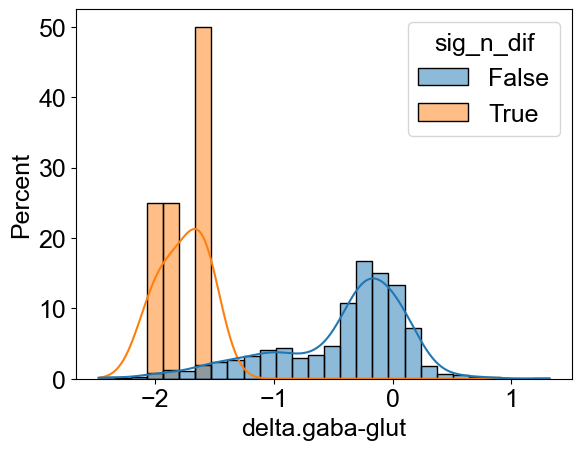

In [20]:
# histogram sig_n_dif
sns.histplot(x="delta.gaba-glut", data=enh, hue="sig_n_dif", kde=True, stat="percent", common_norm=False)
out = os.path.join(RE,"delta.distribution.sig_n_dif.syn.pdf")
plt.savefig(out, bbox_inches='tight')

In [21]:
4/964

0.004149377593360996

[Text(0.5, 0, 'mean GLUT'), Text(0, 0.5, 'mean GABA')]

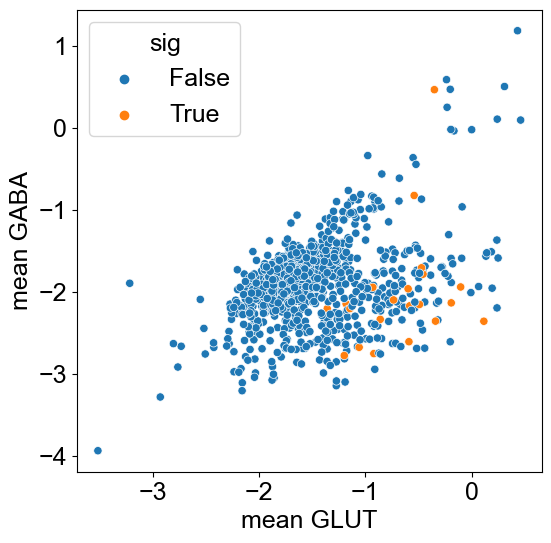

In [22]:
# effect sizes of sig and dif
fig, ax= plt.subplots(figsize=(6,6))
y="gaba" 
x="glut" 
data=enh 
hue="sig"
sns.scatterplot(x=x, y=y, data=data, hue=hue)
out = os.path.join(RE, "cell-type-dif.scatter.syn.pdf")
ax.set(xlabel="mean GLUT", 
      ylabel="mean GABA")
#plt.savefig(out, bbox_inches='tight')

In [23]:
enh.head()

,name,sequence,bkgd,72h,ctrl,cl,coor,top_bottom,strand,#chr,...,-log10p_fdr,gaba_1,gaba_2,gaba_3,glut_1,glut_2,glut_3,pval,fdr_bool,sig_n_dif
0,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,...,0.759672,-2.421393,-2.184369,-2.227760,-1.956195,-1.840061,-1.376951,0.072685,False,False
1,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,...,0.087369,-2.019538,-1.677746,-2.074945,-2.181752,-1.903716,-1.406938,0.741336,False,False
2,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,...,1.209370,-2.352699,-2.466286,-2.295281,-2.131924,-1.977559,-2.010440,0.008621,False,False
4,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,...,0.228309,-2.211512,-1.975496,-2.338388,-2.062864,-1.947051,-2.200030,0.466315,False,False
5,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,...,0.715947,-2.011400,-2.025084,-1.661753,-1.494240,-1.735514,-1.415115,0.086300,False,False


# synthetic design matrix

In [24]:
eg = enh["name"][0]

In [59]:
enh["name"]

0       Backgroundseq2chr1:244100624-244100893:+|Pos:1...
1       Backgroundseq2chr1:244100624-244100893:+|Pos:1...
2       Backgroundseq2chr1:244100624-244100893:+|Pos:1...
4       Backgroundseq2chr1:244100624-244100893:+|Pos:1...
5       Backgroundseq2chr1:244100624-244100893:+|Pos:1...
                              ...                        
1289    Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...
1291    Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...
1292    Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...
1294    Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...
1295    Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...
Name: name, Length: 968, dtype: object

In [100]:
c, sample_dict = Counter(), {}

for eg in set(enh["name"]):
    # handle str splitting pipe issue
    if "|Motif2" in eg:
        eg = eg.replace("|Motif2", ",Motif2")

    # get information from name w/ pipe str split
    name_info, pos, motif_name, motif = eg.split("|")

    if "chr" in eg:
        template, coor = name_info.split("seq2")
        template = "Background" + "seq2"

    else:
        template, coor = name_info.split("seq1")
        template = "Background" + "seq1"

    # get individual information from comma str split
    pos_list, motifname_list, motifseq_list = pos.split(
        ","), motif_name.split(","), motif.split(",")

    # handle case when two different motifs are inserted.
    if len(motifname_list) == 2 and len(pos_list) == 2:

        # iterate through position indexes
        for n, mpos in enumerate(pos_list):
            mname, mseq = motifname_list[n], motifseq_list[n]
            sample_dict[(eg+f".{n}")] = [eg, template, coor, n,
                                         mpos.strip("Pos").split(":")[1],
                                         mname.split(":")[1],
                                         mseq.split(":")[1],
                                         len(pos_list)
                                         ]  # add to the dictionary

    # else, one motif is inserted multiple times.
    else:
        mname, mseq = motifname_list[0], motifseq_list[0]

        # iterate through positions w/ same motif.
        for n, mpos in enumerate(pos_list):
            sample_dict[(eg+f".{n}")] = [eg, template, coor, n,
                                         mpos.strip("Pos:"),
                                         mname.split(":")[1],
                                         mseq.split(":")[1],
                                         len(pos_list)
                                         ]  # add to the dictionary

            # c[len(motifseq_list)] +=1 # count how many instances of one or two motifs inserts there are.

In [102]:
syn = pd.DataFrame(np.vstack(sample_dict.values())).sort_values(by=7)
syn.columns = ['name', "bkgdseq", "coor", "insert_no",
               "insert_pos", "motif_id", "motif", "insert_n"]
syn

,name,bkgdseq,coor,insert_no,insert_pos,motif_id,motif,insert_n
1025,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,Backgroundseq2,chr1:244100624-244100893:+,0,135,glutmotif1,TGAACTGCTACA,1
675,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,Backgroundseq2,chr1:244100624-244100893:+,0,135,gabamotif1,AAACACATTAGG,1
1951,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,Backgroundseq2,chr1:244100624-244100893:+,0,135,glutmotif3,TGAGATCTTAAA,1
394,Backgroundseq172hr_top_98|Pos:135|Motiffamily:...,Backgroundseq1,72hr_top_98,0,135,glutmotif2,TTCCTCATATGT,1
1695,Backgroundseq172hr_top_98|Pos:135|Motiffamily:...,Backgroundseq1,72hr_top_98,0,135,glutmotif2,TTCCTCATGTGT,1
...,...,...,...,...,...,...,...,...
1749,"Backgroundseq172hr_top_98|Pos:105,125,145,165|...",Backgroundseq1,72hr_top_98,2,145,glutmotif2,TTCATTATGTGT,4
1748,"Backgroundseq172hr_top_98|Pos:105,125,145,165|...",Backgroundseq1,72hr_top_98,1,125,glutmotif2,TTCATTATGTGT,4
1747,"Backgroundseq172hr_top_98|Pos:105,125,145,165|...",Backgroundseq1,72hr_top_98,0,105,glutmotif2,TTCATTATGTGT,4
239,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,Backgroundseq2,chr1:244100624-244100893:+,1,125,glutmotif1,TGAACTGCTACA,4


In [107]:
len(set(syn["motif_id"]))

4

In [108]:
set(syn["motif_id"])

{'gabamotif1', 'glutmotif1', 'glutmotif2', 'glutmotif3'}

info 
    
    motifs = 24 
    insert_positions = 7
    max inserts = 4

    motif_ids = 'gabamotif1', 'glutmotif1', 'glutmotif2', 'glutmotif3'

In [115]:
list(syn)

['name',
 'bkgdseq',
 'coor',
 'insert_no',
 'insert_pos',
 'motif_id',
 'motif',
 'insert_n',
 'gaba_log2_mean',
 'glut_log2_mean']

In [113]:
# add dv
if "gaba_log2_mean" not in list(syn):
    syn = pd.merge(syn, enh[["name", 
                   'gaba_log2_mean',
                   'glut_log2_mean',
                   ]], 
         how='left'
        )

In [114]:
import statsmodels.api as sm

In [121]:
from statsmodels.formula.api import ols

<Axes: xlabel='insert_pos', ylabel='glut_log2_mean'>

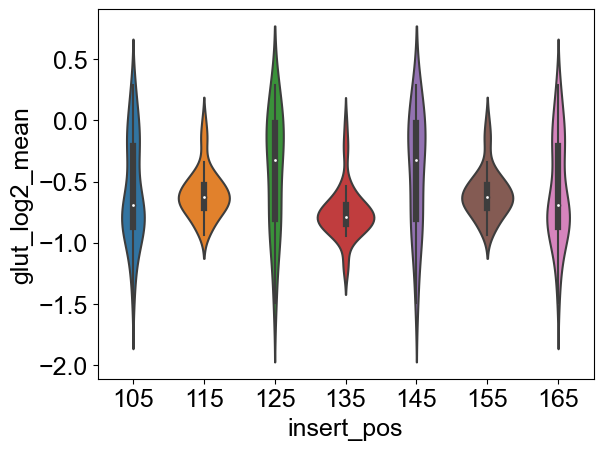

In [143]:
x_vars = ["insert_pos"]
y_var = 'glut_log2_mean'
x_vars.append(y_var)
data = syn[x_vars].drop_duplicates().copy().reset_index()

sns.violinplot(x="insert_pos", y="glut_log2_mean",
               data=data.sort_values(by="insert_pos"))

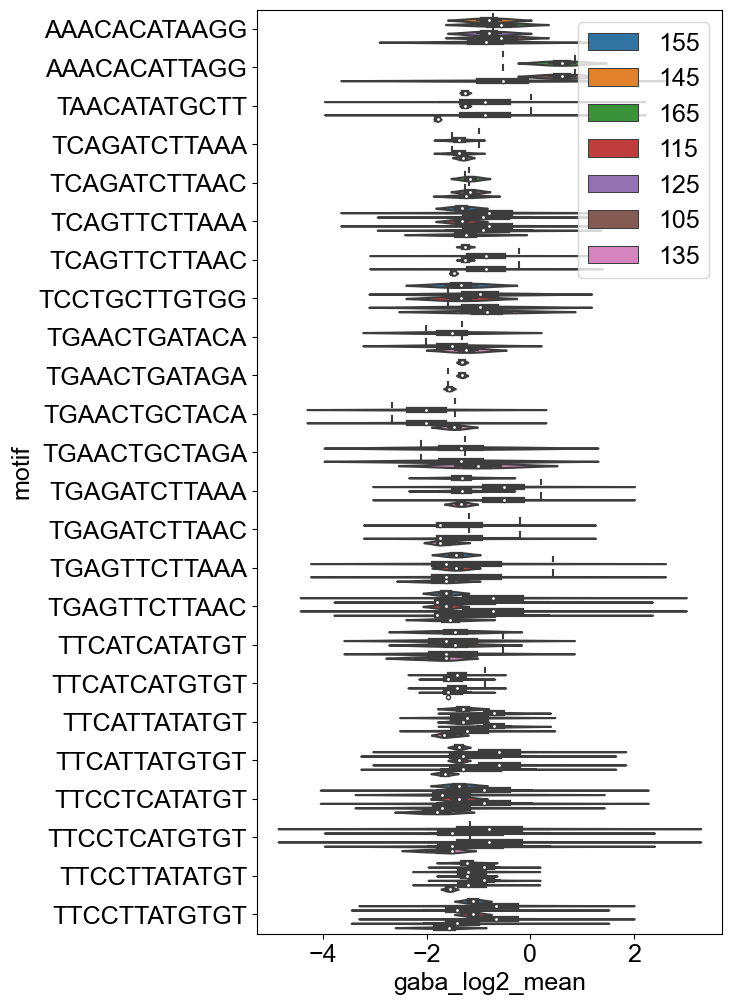

In [148]:
fig, ax = plt.subplots(figsize=(6, 12))
x_vars = ["motif", "insert_pos"]
y_var = 'gaba_log2_mean'
hue = "motif"
x_vars.append(y_var)
data = syn[x_vars].drop_duplicates().copy().reset_index()
sns.violinplot(y=x_vars[0], x=y_var,
               data=data.sort_values(by=x_vars[0]), 
              hue=x_vars[1])
ax.legend(bbox_to_anchor = (1,1))

In [160]:
set(syn["insert_pos"])

{'105', '115', '125', '135', '145', '155', '165'}

In [150]:
data.groupby("motif")["insert_pos"].count()

motif
AAACACATAAGG    16
AAACACATTAGG    12
TAACATATGCTT    14
TCAGATCTTAAA    12
TCAGATCTTAAC    12
TCAGTTCTTAAA    18
TCAGTTCTTAAC    14
TCCTGCTTGTGG    14
TGAACTGATACA    12
TGAACTGATAGA    10
TGAACTGCTACA    12
TGAACTGCTAGA    12
TGAGATCTTAAA    14
TGAGATCTTAAC    15
TGAGTTCTTAAA    17
TGAGTTCTTAAC    18
TTCATCATATGT    17
TTCATCATGTGT    16
TTCATTATATGT    21
TTCATTATGTGT    18
TTCCTCATATGT    22
TTCCTCATGTGT    17
TTCCTTATATGT    18
TTCCTTATGTGT    21
Name: insert_pos, dtype: int64

In [163]:
M = syn.motif
P = syn.insert_pos
y = syn.gaba_log2_mean

formula = "y ~ C(M) + C(P)"  #"+ C(M)*C(P)"  # interaction effect - looks horrible
lm = ols(formula, syn).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     4.174
Date:                Sun, 21 Jan 2024   Prob (F-statistic):           1.10e-10
Time:                        14:39:36   Log-Likelihood:                -295.97
No. Observations:                 324   AIC:                             651.9
Df Residuals:                     294   BIC:                             765.4
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.7130 

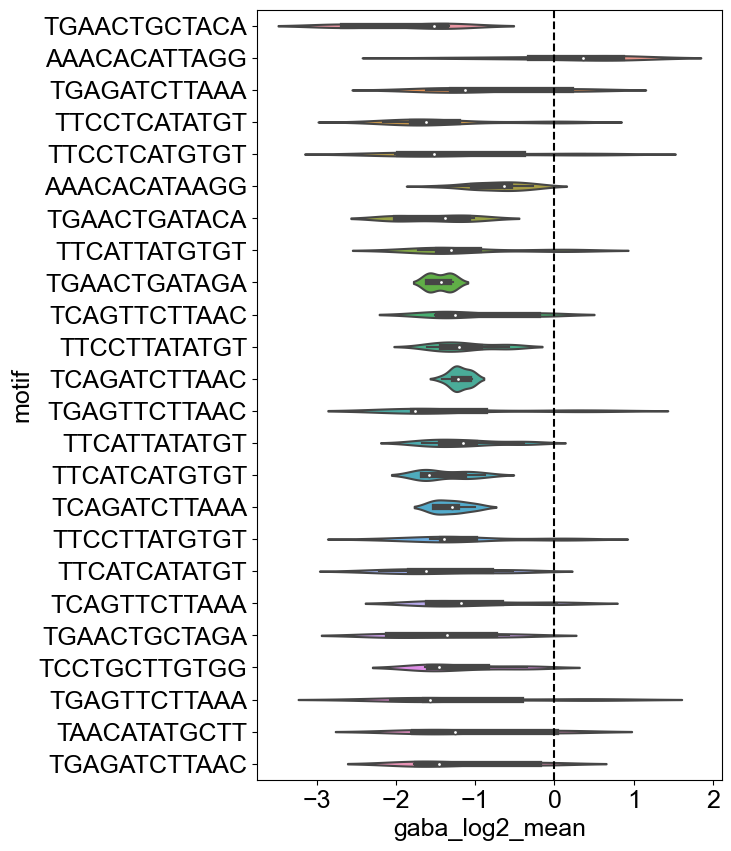

In [172]:
fig, ax = plt.subplots(figsize=(6, 10))
sns.violinplot(x="gaba_log2_mean", 
              y='motif', 
              data=syn)
ax.axvline(0, ls="--", c="k")

In [162]:
M = syn.motif
P = syn.insert_pos
y = syn.glut_log2_mean

formula = "y ~ C(M) + C(P)"  #"+ C(M)*C(P)"  # interaction effect - looks horrible
lm = ols(formula, syn).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     4.892
Date:                Sun, 21 Jan 2024   Prob (F-statistic):           3.51e-13
Time:                        14:39:03   Log-Likelihood:                -82.051
No. Observations:                 324   AIC:                             224.1
Df Residuals:                     294   BIC:                             337.5
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.2629 

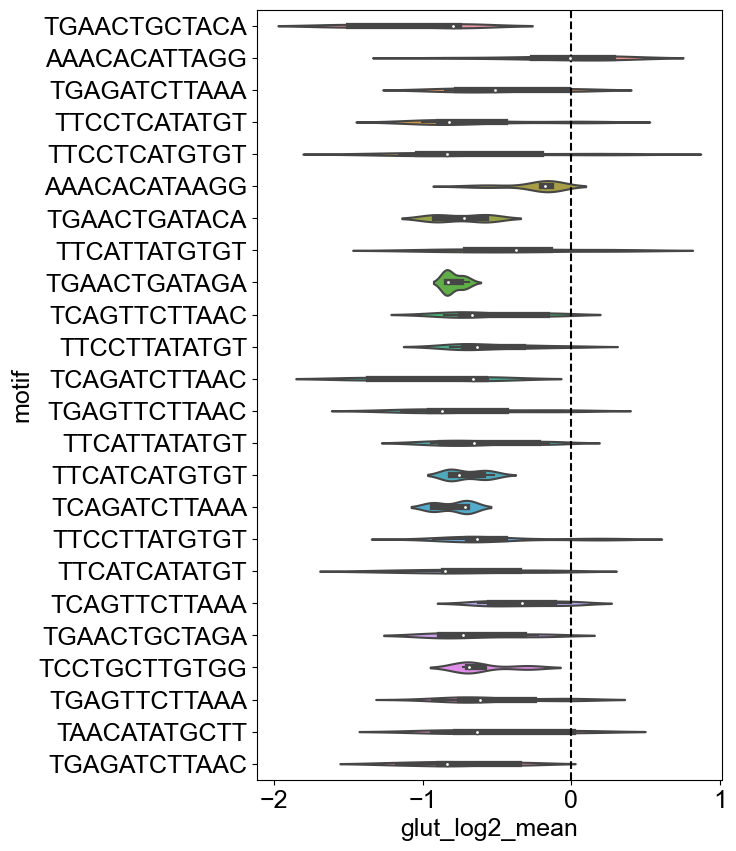

In [171]:
fig, ax = plt.subplots(figsize=(6, 10))
sns.violinplot(x="glut_log2_mean", 
              y='motif', 
              data=syn)
ax.axvline(0, ls="--", c="k")